## 1. Rescoure

* CPU 服务器：

        52.230.49.106(cu01)  
* GPU 服务器：

        157.55.183.144   
        23.102.182.3

note：
1. 数据和数据处理一般都在CPU服务器上，也就是cu01的datadrive文件夹下; model在GPU上运行;
2. source code的最新版本需要在github上，以防止丢失;
3. 不要将过多的文件和数据放在根目录下
4. 在cu01的datadrive下新建自己的文件夹如(v-ensh)来存放临时的数据和需要处理的脚本.其他服务器上可以放在/mnt下
5. 端口号2222，原来是22

###  basic usage

* 使用远程服务器的jupyter：

        对于用用户名密码登录的服务器
        ssh -N -L localhost:9122:localhost:9123 yanlwang@23.102.182.3
        对于要用密钥登录的服务器：
        ssh -i "C:\\Users\\user_name\\.ssh\\id_rsa" -N -L localhost:9124:localhost:9123 yanlwang@52.230.49.106
        
* 文件压缩与解压

    tar -jcvf examples.tar.bz2 examples #zip
    tar -jxvf examples.tar.bz2  #unzip
    
* 数据在服务器之间的传输

   [Linux scp命令](https://www.runoob.com/linux/linux-comm-scp.html)
    
    
* 利用screen运行脚本，防止网络原因程序中止(optional)

        创建：screen -S ###

        查看有多少会话：screen -ls

        恢复：screen -r ###

        如果不能恢复：先screen -d ###

        再screen -r ###

        删除 screen -S ### -X quit
        
* 查看显卡占用率

     watch -n 1 nvidia-smi
     
* 查看和关掉进程
        
     [linux 查看某进程 并杀死进程 ps grep kill](https://blog.csdn.net/shenhuan1104/article/details/75808146)
        
          

## 2 Data
数据处理都在cu01也就是52.230.49.106

我们的数据来源于[CodeSearchNet ](https://github.com/github/CodeSearchNet)，共包含542,991对数据，train，valid和test的比例大约是9.15:0.31:0.54. 

该数据集的存储结构很好，保留的信息很多，但是质量相对来说差一点。

数据的描述见 https://github.com/github/CodeSearchNet/blob/master/notebooks/ExploreData.ipynb

### 2.1 datapreprocess

* input :  

       52.230.49.106/datadrive/Data/csn/csn_ori_java/java/final/jsonl/
       也就是CodeSearchNet下载的的json.gz文件
        
* script: https://github.com/YanlinWang/CodeSum/blob/master/datapreprocess/CodeSearchNet/data_processing.py
的process(), build_voc(),build_dataset()三个函数       

* output:

#### process() 
    1. 52.230.49.106/datadrive/Data/csn/csn.pkl : 加了fid的codesearch文件
    2. 52.230.49.106/datadrive/Data/csn/code/ : 存储处理好的code文件，详细查看readme，文件名的名字依据处理的不同而命名，参数可查参数表
    3. 52.230.49.106/datadrive/Data/csn/summary/:存储处理好的summary文件，详细查看readme，文件名的名字依据处理的不同而命名，参数可查的参数表
    4. 52.230.49.106/datadrive/Data/csn/sbt/:存储处理好的sbt文件，详细查看readme，文件名的名字依据处理的不同而命名，参数可查的参数表     
#### build_voc()
    1.  52.230.49.106/datadrive/Data/csn/vocab_raw/code_word_count_****.pkl: 特定code参数处理后的词频表，例如code_word_count_djl1_dfp0_dsi1_dlc1_dr1.pkl
    2.  52.230.49.106/datadrive/Data/csn/vocab_raw/summary_word_count_.pkl：特定summary参数处理后的词频表，例如summary_word_count_cfp1_csi1_cfd0_clc1.pkl
    3.  52.230.49.106/datadrive/Data/csn/vocab_raw/sbts_tokens.pkl： sbt的token词频表
    4.  52.230.49.106/datadrive/Data/csn/vocab_raw/csn_trainingset_djl1_dfp0_dsi1_dlc1_dr1_cfp1_csi1_cfd0_clc1.json：存储word2idex和index2word
    以上四个文件都可查对应文件夹下的readme   
#### build_dataset()
    52.230.49.106/datadrive/Data/csn/dataset/dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl：dataset存储train,valid,test下的code(d),summmary(c),sbt(s)的数字化形式以及他们的vocabulary，w2i,i2w和词频 以及 uml的信息,下图中没有体现
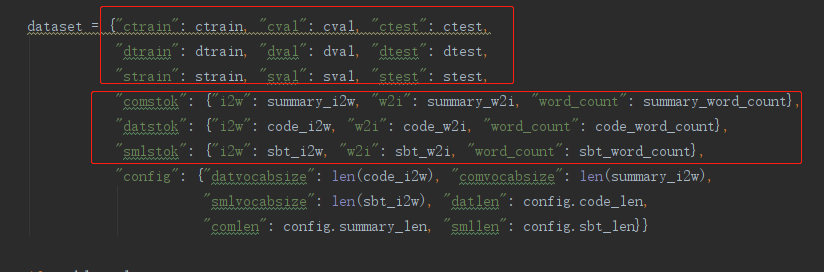

datapreprocess分为三个部分

#### process() 

1. add fid
2. 对source code分别进行下图hyper_parameters绿色字体中的五种操作，最终根据不同参数的结果，最终选用红色框框出来的结果
3. 对summary分别进行下图hyper_parameters红色字体中的三种操作，最终根据不同参数的结果，最终选用红色框框出来的结果
4. 对sbt按照[lecalir](https://arxiv.org/abs/1902.01954)的做法
5. 对于uml得到node的信息和edge的信息 [code](https://github.com/YanlinWang/CodeSum/blob/master/datapreprocess/CodeSearchNet/get_sbt_csn.py)

#### build_voc()
读入处理好的code,summary和sbt的pkl文件，例如读入/code/djl1_dfp0_dsi1_dlc1_dr1.pkl, /summarycfp1_csi1_cfd0_clc1.pkl, sbt/sbts_tokens.pkl按照词序和给定的字典长度得到code,summary和sbt三个字典。后面的uml也是单独一个vocabulary

#### build_dataset()
建立词表，确定最大长度，截断与padding，并且数字化文本形式的code,summary与sbt



#### hyper_parameter
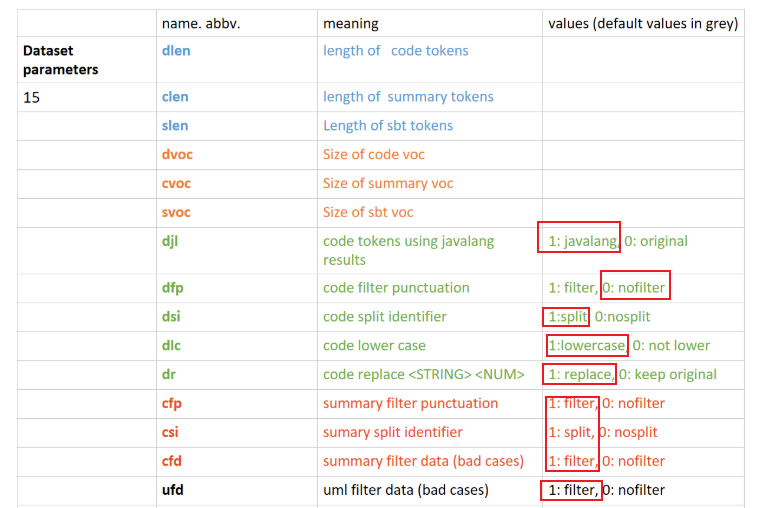


### 2.2 filtering rules

hyper-parameter中提到的filter bad case的规则        
        
        1 Code snippets with missing GitHub repositories are removed.
        2 Code snippets that cannot be processed by UMLGraph2 to build
        UML class diagrams are removed.
        3 Summaries shorter than three words are removed.
        4 Non-English summaries are removed
 
过滤后剩下267,047 pairs of source code and summaries，train，valid和test比例大概为9：0.4：0.6

###  2.3 UML的处理

* doc ： https://1drv.ms/w/s!At8JcE7zz_27iVmb9CtKKnPJgaQg?e=dB0hmt
* script ： https://github.com/YanlinWang/CodeSum/blob/master/datapreprocess/CodeSearchNet/get_sbt_csn.py
* ouput:
/datadrive/Data/csn/uml/umls.pkl

再进一步处理可得到:

    dataset_uml.pkl
    m2u_m2c.pkl
    uml_dataset.pt

### 2. 4 处理过后的数据汇总 
52.230.49.106/datadrive/Data/csn/下

    1. csn.pkl : 加了fid的codesearch文件
    2. code/ : 存储处理好的code文件，详细查看readme，文件名的名字依据处理的不同而命令，参数可查参数表
    3. summary/:存储处理好的summary文件，详细查看readme，文件名的名字依据处理的不同而命令，参数可查的参数表
    4. sbt/:存储处理好的sbt文件，详细查看readme，文件名的名字依据处理的不同而命令，参数可查的参数表 
    5. uml/: 存储uml的文件，详情可查https://1drv.ms/w/s!At8JcE7zz_27iVmb9CtKKnPJgaQg?e=dB0hmt
    6. vocab_raw/：存储词频和vocabulary
    word2idex和index2word
    
    7.  /dataset/：存储dataset
    8. /method_wise/和 package_wise是train,valid，test的划分比例，结构和52.230.49.106/datadrive/Data/csn类似

## 3. Model 

可参考论文和[ppt](https://1drv.ms/p/s!At8JcE7zz_27iwGbDYLe4u7Wetrq?e=ypyJQh)


model可用脚本来跑

script https://github.com/YanlinWang/CodeSum/tree/master/script
    
   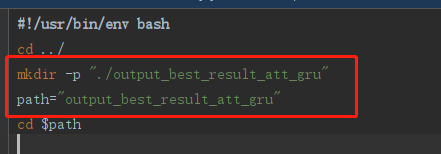 
 
生成的best model和log文件保存在此文件夹下


## 4. Experiment

model预测的结果并未保存，需要单独加载模型保存

52.230.49.106/datadrive/Data/csn/下

计算不同模型的预测结果 datadrive/Data/csn/diff_decoder_and_metric.ipynb

加载不同模型的预测结果，得到不同code len 和 summary 的结果 /datadrive/Data/csn/plot_diff_code_summary_len.ipynb